## Regression and quantile regression

**Normal regression** can be intepreted as the expected conditional mean of the target, across a population with same X: $\mathbb{E}(Y|X)$.

**Quantile regression** - predicts median and quartiles (or quantiles) of predictions. 

To create conformal intervals, we can choose one of two strategies:
- Starting from point predictions

- Starting from (non-conformal) intervals generated by quantile regression

Conformal prediction is a technique used to estimate prediction intervals in regression problems, providing a range of values that are guaranteed to cover the true value with a high probability. Here's a simplified explanation of how it works:

- *Data Splitting*: The data is split into a training set and a calibration set. The model is trained on the training data.

- *Non-conformity Scores*: These are computed using the calibration data and the trained model. In the context of regression, the non-conformity score is typically the absolute residual of the prediction.

- *Threshold Determination*: A threshold (q) is determined such that a certain proportion (1-α) of the predictions have a non-conformity score below this threshold, and α have a score above it.

- *Prediction Interval Formation*: For a new data point, the prediction interval includes all possible target values (y's) that produce a non-conformity score below the threshold.

There are two main approaches to conformal prediction in regression:

- *Conformalized Mean Regression*: This approach starts with a point prediction from a regression model and uses conformal prediction to turn this into a prediction interval.

- *Conformalized Quantile Regression*: This approach starts with intervals produced by quantile regression and applies conformal prediction to these intervals. The score used in this case is positive if the true value y lies outside of the interval, and negative if it lies inside.

It's important to note that the validity of conformal prediction relies on the assumption of exchangeability, meaning that the data points are sampled independently from a fixed but unknown probability distribution


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from mapie.regression import MapieRegressor


X, y = make_regression(n_samples=1000, n_features=1, noise=4.0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
# Split off model training set
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.5, random_state=42)
# Split rest into calibration and test
X_Cal, X_test, y_cal, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)


In [2]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
from sklearn.metrics import mean_absolute_error
# Make predictions using the fitted model
y_pred = model.predict(X_test)
# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(round(mae, 2))

3.89


In [3]:
# Define regressor
regressor = RandomForestRegressor()
# Fit regressor and MAPIE model together (used 5-fold k-fold)
mapie_regressor = MapieRegressor(estimator=regressor, method='plus', cv=5)
mapie_regressor.fit(X_train, y_train)
# Get predictions and prediction intervals
y_pred, y_pis = mapie_regressor.predict(X_test, alpha=0.05)
y_pis = y_pis.squeeze() # Remove redundant dimensions
# Show first five examples
y_pred[0:5]

array([-22.24606447, -21.24859751,  17.23650966,  -3.50391206,
       -23.6822311 ])

In [4]:
y_pis[0:5]

array([[-33.63538336, -12.14139001],
       [-31.70104913,  -8.56575313],
       [  1.01956819,  26.67218456],
       [-14.16388278,   6.69911559],
       [-34.20523054, -12.75659403]])

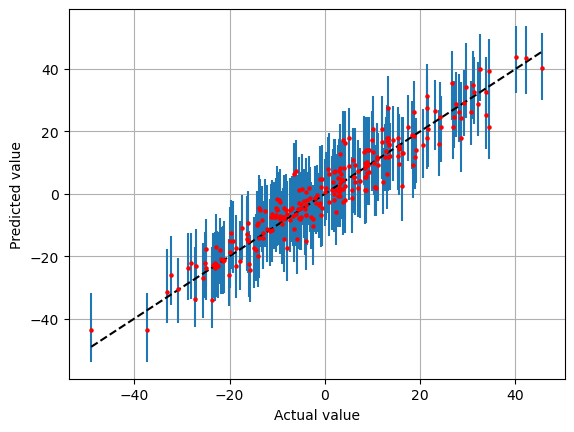

In [5]:
# Get coverage limits either side of predicted value
lower_error = y_pred - y_pis[:, 0]
upper_error = y_pis[:, 1] - y_pred

# Set up chart
fig = plt.figure()
ax = fig.add_subplot()

# Add error bars
ax.errorbar(
    x = y_test,
    y = y_pred,
    yerr = [lower_error, upper_error],
    fmt='none')

# Add points
ax.scatter(y_test, y_pred, color='r', s=5, zorder=10)

# Add equality line
y_min = y_test.min()
y_max = y_test.max()
ax.plot([y_min, y_max], [y_min, y_max], color='k', linestyle='dashed')

# Add 'stuff'
ax.set_xlabel('Actual value')
ax.set_ylabel('Predicted value')
ax.grid()

# Show
plt.show()